# **EMI Stress Analysis of Approved Loan Borrowers**

**<h3>3. Borrower Risk Analysis**

**<h4>I. Risk Segmentation (EMI Stress Buckets)**

In [ ]:
-- adding risk segment column

ALTER TABLE loan_new
ADD COLUMN risk_segment VARCHAR(20);


UPDATE loan_new
SET risk_segment = CASE
    WHEN emi_to_income_ratio < 20 THEN 'Low Risk'
    WHEN emi_to_income_ratio BETWEEN 20 AND 40 THEN 'Moderate Risk'
    ELSE 'High Risk'
END;


-- Count & Percentage of borrowers in each segment

SELECT
    risk_segment,
    COUNT(*) AS borrower_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM loan_new), 2) AS percentage
FROM loan_new
GROUP BY risk_segment;

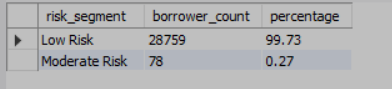

**<h4>II. Borrower Characteristics and Risk Behavior**

**1. Income vs Loan Amount**

In [ ]:
SELECT
    risk_segment,
    ROUND(AVG(annual_inc),2) AS avg_income,
    ROUND(AVG(loan_amnt),2) AS avg_loan_amount,
    ROUND(AVG(installment),2) AS avg_emi
FROM loan_new
GROUP BY risk_segment
ORDER BY FIELD(risk_segment, 'Low Risk','Moderate Risk');

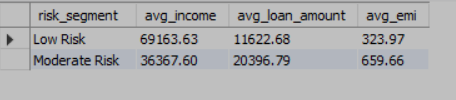

**Income matters:** Even if someone has a moderate loan, low income increases stress.

**Loan size matters:** Moderate Risk borrowers have larger loans relative to their income leading to higher EMI-to-Income ratio.

**EMI reflects risk:** EMI is almost double for Moderate Risk compared to Low Risk

Moderate Risk borrowers earn less but have larger loans and higher EMIs. Banks should monitor this segment closely, as they are more vulnerable to income shocks or interest rate hikes.

**2. DTI vs Risk Segment**

In [ ]:
SELECT
    risk_segment,
    ROUND(AVG(dti),2) AS avg_dti,
    COUNT(*) AS borrower_count
FROM loan_new
GROUP BY risk_segment;

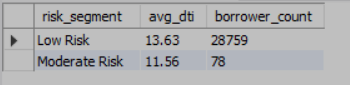

DTI alone does not fully explain EMI stress here.

Moderate Risk borrowers have higher EMIs relative to their income, even though DTI is lower, likely because their loan amount is large relative to their income.

EMI-to-Income captures short-term repayment burden, while DTI is more overall debt picture.

Moderate Risk borrowers have slightly lower total debt ratios but higher EMI burden relative to income. This shows banks should monitor EMI-to-Income more closely than DTI for early warning signals in approved borrowers.

**3. Revolving Credit Utilization vs Risk Segment**

In [ ]:
SELECT
    risk_segment,
    ROUND(AVG(revol_util),2) AS avg_revol_util,
    COUNT(*) AS borrower_count
FROM loan_new
GROUP BY risk_segment;

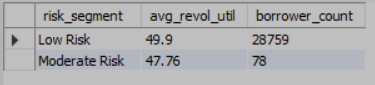

Revolving utilization does not directly drive EMI stress here.

Moderate Risk borrowers have higher EMI-to-Income ratios, even though they slightly underutilize revolving credit.

Indicates that loan size and income, not credit card usage, is the main driver of risk in this approved borrower dataset.

**4. Loan purpose vs stress**

In [ ]:
SELECT
    risk_segment,
    purpose,
    COUNT(*) AS borrower_count,
    ROUND(AVG(emi_to_income_ratio),2) AS avg_emi_to_income
FROM loan_new
GROUP BY risk_segment, purpose
ORDER BY risk_segment, avg_emi_to_income DESC;

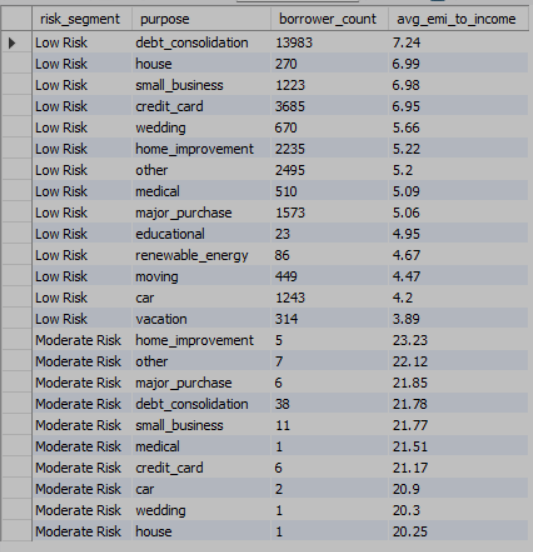

Debt Consolidation & Small Business Loans are high-volume categories; even a few moderate-risk borrowers in these can affect portfolio stability.

Moderate Risk borrowers, though few, carry high EMI-to-Income ratios, making them early warning candidates for monitoring.

Purpose alone does not determine stress; it interacts with income and loan size.

Banks should focus on EMI-to-Income ratio and risk segmentation rather than purely loan purpose when assessing borrower stress.

**<h4>III. Loan Risk Analysis (High-Value Metrics)**

**1. Loan Term vs EMI Stress**

In [ ]:
SELECT
    term,
    COUNT(*) AS borrower_count,
    ROUND(AVG(emi_to_income_ratio),2) AS avg_emi_to_income,
    ROUND(SUM(CASE WHEN risk_segment='Moderate Risk' THEN 1 ELSE 0 END)/COUNT(*)*100,2) AS pct_moderate_risk
FROM loan_new
GROUP BY term
ORDER BY term;


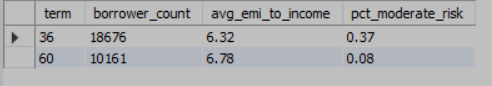

Shorter-tenure loans increase monthly EMI stress, even for approved borrowers.

Longer tenure reduces stress, making repayment more manageable.

**2. Interest Rate vs EMI Stress**

In [ ]:
SELECT
    CASE
        WHEN int_rate < 10 THEN '<10%'
        WHEN int_rate BETWEEN 10 AND 15 THEN '10-15%'
        WHEN int_rate BETWEEN 15 AND 20 THEN '15-20%'
        ELSE '20%+'
    END AS int_rate_bucket,
    COUNT(*) AS borrower_count,
    ROUND(AVG(emi_to_income_ratio),2) AS avg_emi_to_income,
    ROUND(SUM(CASE WHEN risk_segment='Moderate Risk' THEN 1 ELSE 0 END)/COUNT(*)*100,2) AS pct_moderate_risk
FROM loan_new
GROUP BY int_rate_bucket
ORDER BY int_rate_bucket;


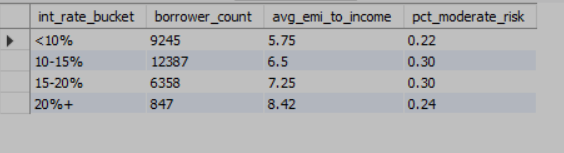

Higher EMI-to-Income increases stress, most moderate-risk borrowers fall in the 10–20% range. We need to focus monitoring here.

**3. Loan Grade vs EMI Stress**

In [ ]:
SELECT
    grade,
    COUNT(*) AS borrower_count,
    ROUND(AVG(emi_to_income_ratio),2) AS avg_emi_to_income,
    ROUND(SUM(CASE WHEN risk_segment='Moderate Risk' THEN 1 ELSE 0 END)/COUNT(*)*100,2) AS pct_moderate_risk
FROM loan_new
GROUP BY grade
ORDER BY grade;


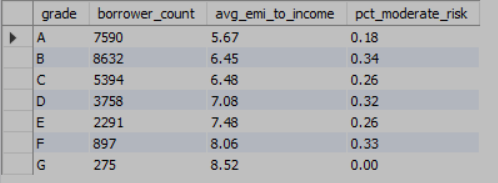

EMI-to-Income rises from grade A to F, but moderate-risk borrowers also exist in B and D grades.    Traditional credit grades do not fully capture EMI stress, monitoring should include EMI-to-Income, not just grade.

**<h4>IV. Portfolio Stress Simulation**

**10% income drop + 2% interest rate hike**

In [ ]:
ALTER TABLE loan_new
ADD COLUMN emi_stress FLOAT,
ADD COLUMN emi_to_income_stress FLOAT,
ADD COLUMN risk_segment_stress VARCHAR(20);


UPDATE loan_new
SET emi_stress = ROUND(
    loan_amnt * (( (int_rate + 2)/100/12 ) * POW(1 + ( (int_rate + 2)/100/12 ), term)) /
    (POW(1 + ((int_rate + 2)/100/12), term) - 1), 2
)
WHERE id IS NOT NULL;


UPDATE loan_new
SET emi_to_income_stress = ROUND((emi_stress * 12 * 100.0) / (annual_inc * 0.9), 2)
WHERE id IS NOT NULL;


UPDATE loan_new
SET risk_segment_stress = CASE
    WHEN emi_to_income_stress < 20 THEN 'Low Risk'
    WHEN emi_to_income_stress BETWEEN 20 AND 40 THEN 'Moderate Risk'
END
WHERE id IS NOT NULL;


In [ ]:
SELECT
    risk_segment_stress,
    COUNT(*) AS borrower_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM loan_new), 2) AS percentage
FROM loan_new
GROUP BY risk_segment_stress;


SELECT COUNT(*) AS shifted_to_moderate
FROM loan_new
WHERE risk_segment = 'Low Risk'
  AND risk_segment_stress = 'Moderate Risk';

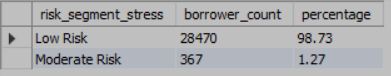

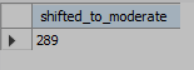

**Understanding why 289 users shifted from low to moderate risk**

**By Loan Purpose**

In [ ]:
SELECT
    purpose,
    COUNT(*) AS shifted_count
FROM loan_new
WHERE risk_segment = 'Low Risk'
  AND risk_segment_stress = 'Moderate Risk'
GROUP BY purpose
ORDER BY shifted_count DESC;


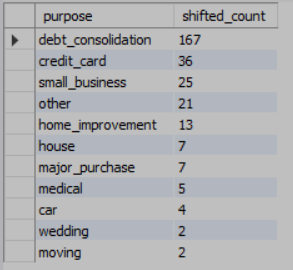

**By Loan Grade**

In [ ]:
SELECT
    grade,
    COUNT(*) AS shifted_count
FROM loan_new
WHERE risk_segment = 'Low Risk'
  AND risk_segment_stress = 'Moderate Risk'
GROUP BY grade
ORDER BY shifted_count DESC;


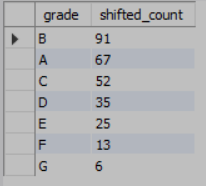

**By Loan Term**

In [ ]:
SELECT
    term,
    COUNT(*) AS shifted_count
FROM loan_new
WHERE risk_segment = 'Low Risk'
  AND risk_segment_stress = 'Moderate Risk'
GROUP BY term;


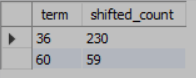

**By Income Buckets**

In [ ]:
WITH income_classified AS (
    SELECT
        CASE
            WHEN annual_inc < 40000 THEN '<40k'
            WHEN annual_inc BETWEEN 40000 AND 80000 THEN '40k-80k'
            WHEN annual_inc BETWEEN 80000 AND 120000 THEN '80k-120k'
            ELSE '120k+'
        END AS income_bucket
    FROM loan_new
    WHERE risk_segment = 'Low Risk'
      AND risk_segment_stress = 'Moderate Risk'
)
SELECT income_bucket, COUNT(*) AS shifted_count
FROM income_classified
GROUP BY income_bucket
ORDER BY shifted_count DESC;


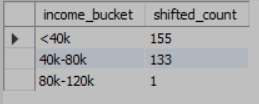

The borrowers who are most vulnerable to income shocks are:

**1. Low-to-Mid Income Borrowers (<80k)**

They make up almost all stress shifts.

Even small income drops push them into moderate EMI stress.

<br>

**2. Debt Consolidation & Credit Card Loans**

Together, they dominate stress shifts.

These borrowers are already managing multiple debts, so adding a new EMI makes their finances more fragile.

<br>

**3. Shorter-Term Loans (36 months)**

Majority of stress shifts come from here.

Higher EMIs (due to shorter repayment window) make them highly sensitive to income drops.

<br>

**4. Grades A & B (Prime Borrowers)**

Surprisingly, many stress shifts happen here.

This suggests that traditional credit grades may underestimate EMI stress, since a strong credit history doesn’t always guarantee repayment comfort when incomes fall.

**Borrowers with low-to-mid incomes taking high-EMI loans (often for debt consolidation/credit cards), especially on shorter tenures, are the most vulnerable.**

<br>

**<h4>RECOMMENDATIONS:**  
<br>
**EMI Stress Tests**

We can simulate a 10–20% income drop at loan approval stage.

Then approve or restructure based on whether the borrower stays in safe stress buckets.

<br>

**Affordability Score with Credit Grades**

Combine traditional grades (A–G) with an “EMI-to-Income score”.

This gives a more accurate idea of repayment comfort, even for Grade A/B borrowers.

<br>

**Purpose-Specific Risk Monitoring**

We need to pay special attention to debt consolidation and credit card loans, which dominate stress shifts.

Building early warning dashboards by loan purpose can also be done.

**<h4>V. High-Risk Personas**

**1. Borrower Risk by Income and Home Ownership**

In [ ]:
-- Income Bucket + Home Ownership
SELECT
  income_bucket,
  home_ownership,
  COUNT(*) AS total_loans,
  SUM(default_flag) AS total_defaults,
  ROUND(SUM(default_flag)/COUNT(*) * 100, 2) AS default_rate_pct
FROM loan_new
GROUP BY income_bucket, home_ownership
ORDER BY income_bucket, home_ownership;

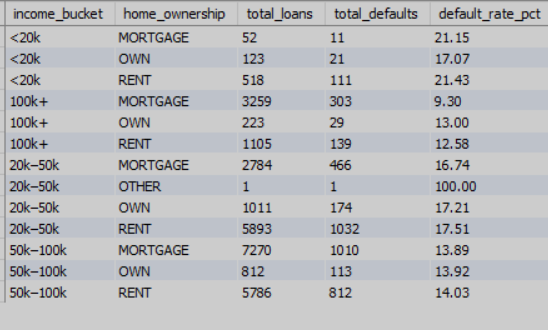

Borrowers earning <20k have the highest default rates, especially renters (21.43%) and mortgage holders (21.15%). Default risk generally decreases with income, and home ownership mainly impacts risk at lower income levels.

**2. Do renters having low-income and high-interest loans default the most?**

In [ ]:
-- income + interest

SELECT
    home_ownership,
    income_bucket,
    COUNT(*) AS total_loans,
    SUM(default_flag) AS total_defaults,
    ROUND(SUM(default_flag) / COUNT(*) * 100, 2) AS default_rate_percent
FROM loan_new
GROUP BY home_ownership, income_bucket
ORDER BY default_rate_percent DESC;

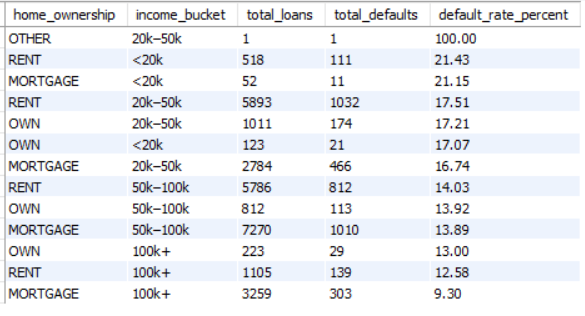

Low-income borrowers (<20k) are most at risk, especially renters and mortgage holders. Default rates decline as income rises, and home ownership mainly affects risk at lower incomes.

**3. Are high DTI and high revol_util (credit card usage) borrowers the most risky?**

In [ ]:
-- creating dti bucket

ALTER TABLE loan_new ADD COLUMN dti_bucket VARCHAR(20);

UPDATE loan_new
SET dti_bucket =
    CASE
        WHEN dti < 10 THEN 'Low DTI'
        WHEN dti BETWEEN 10 AND 20 THEN 'Medium DTI'
        ELSE 'High DTI'
    END;

In [ ]:
-- create revol_util bucket

ALTER TABLE loan_new ADD COLUMN revol_util_bucket VARCHAR(20);

UPDATE loan_new
SET revol_util_bucket =
    CASE
        WHEN revol_util < 30 THEN 'Low Util'
        WHEN revol_util BETWEEN 30 AND 70 THEN 'Medium Util'
        ELSE 'High Util'
    END;

In [ ]:
-- combining both

SELECT
    dti_bucket,
    revol_util_bucket,
    COUNT(*) AS total_loans,
    SUM(default_flag) AS total_defaults,
    ROUND(SUM(default_flag) / COUNT(*) * 100, 2) AS default_rate_percent
FROM loan_new
GROUP BY dti_bucket, revol_util_bucket
ORDER BY default_rate_percent DESC;


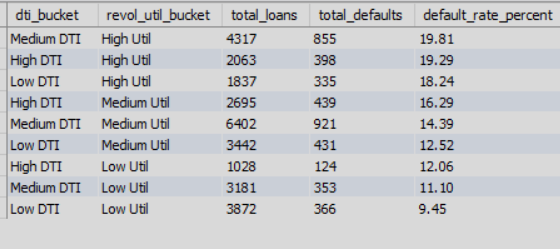

Borrowers with high revolving credit utilization face the highest default risk, even if their DTI is low. Low utilization keeps risk low, showing that credit usage is a stronger predictor of default than DTI.

# **Final Insight**

**Income & Loan Size:** Low-to-mid income borrowers with large EMIs relative to income are the most vulnerable, even among approved borrowers.

**Loan Term & Type:** Short-term loans, debt consolidation, and credit card loans increase repayment stress.

**Credit Grades:** Traditional credit grades (A–F) do not fully capture EMI stress; moderate-risk borrowers exist across all grades.

**Revolving Utilization:** High revolving credit usage is a stronger predictor of default than DTI alone.

**Stress Testing:** Simulated scenarios (e.g., 10% income drop + 2% interest hike) reveal hidden vulnerabilities, including among prime borrowers.

**Recommendation:** Banks should monitor EMI-to-Income ratios, moderate-risk borrowers, and low-income, high-utilization segments to reduce potential defaults and maintain portfolio stability.